In [1]:
import sys, os
sys.path.append(os.path.abspath('../'))
sys.path.append(os.path.abspath('../modules/'))
from modules.settings import global_mmf_settings as gset
#from modules import evaluate_Y_M_scaling_reln_cosmo_cat as ymsr
from wrapper_scripts import evaluate_Y_M_scaling_reln_cosmo_cat as ymsr
from modules.settings import global_mmf_settings as gset
from cosmology import cosmo_fn
import multiprocessing as mp
from scipy.optimize import curve_fit
import bces.bces as bces
import time
from astropy.io import fits

%pylab notebook

def return_log_err(gauss_mean,gauss_err,num_samples=100000,ignore_negatives=True):
    logerr=np.zeros_like(gauss_mean)
    for idx, mu in enumerate(gauss_mean):
        x=np.random.normal(mu,gauss_err[idx],num_samples)
        if ignore_negatives:
            while np.any(x<0):
                neg_idx=np.where(x<0)[0]
                x[neg_idx]=np.random.normal(mu,gauss_err[idx],np.size(neg_idx))
        logerr[idx]=np.std(log10(x))
    return logerr

Populating the interactive namespace from numpy and matplotlib


# Initialize MMF analysis

In [99]:
outpath="../../results/planck_pr3/planck_cosmo_cat/"
tempdatapath="../../results/planck_pr3/data/"
#outpath="/nvme/arotti/mmf_dataout/planck_pr1/planck_cosmo_cat/"
gset.setup_mmf_config(dataset="planck_pr3",outpath=outpath,tempdatapath=tempdatapath,chmin=100.,xsize=10.,do_band_pass=True)
figpath=gset.mmfset.paths["result_figs"]
pmmf=ymsr.Y_M_scaling()
xsz_cat=pmmf.xsz_cat

def wrap_eval_Y500_xray_prior(idx):
    result=pmmf.eval_Y500_xray_prior(idx)
    return result

def parallel_eval_Y500_xray_prior(numprocs):
    pool=mp.Pool(processes=numprocs)
    result=pool.map(wrap_eval_Y500_xray_prior,pmmf.idx_list)
    pool.close()
    pool.join()
    return np.array(result)

def wrap_eval_Y500_xray_prior_iterative(idx):
    result=pmmf.eval_Y500_xray_prior_iterative(idx)
    return result

def parallel_eval_Y500_xray_prior_iterative(numprocs):
    pool=mp.Pool(processes=numprocs)
    result=pool.map(wrap_eval_Y500_xray_prior_iterative,pmmf.idx_list)
    pool.close()
    pool.join()
    return np.array(result)

def wrap_eval_Y500_blind(idx):
    result=pmmf.eval_Y500_blind(idx)
    return result

def parallel_eval_Y500_blind(numprocs):
    pool=mp.Pool(processes=numprocs)
    result=pool.map(wrap_eval_Y500_blind,pmmf.idx_list)
    pool.close()
    pool.join()
    return np.array(result)

# Extract data tangent planes

In [100]:
# ymsr.ppd.extract_tangent_planes()

# Merge Ysz catalogue with xsz catalogue

In [101]:
ysz_cat=ymsr.ppd.get_cosmo_catalogue_ysz()
xsz_cat["BIAS"]=np.copy(ysz_cat["BIAS"])
xsz_cat["T500"]=np.copy(xsz_cat["TX"])
xsz_cat["M500"]=np.copy(ysz_cat["M_Yx_500"]/1e14)
xsz_cat["M500_err"]=(ysz_cat['ERRM_M_Yx_500'] + ysz_cat['ERRP_M_Yx_500'])*0.5/1e14
xsz_cat["YSZ_500"]=np.copy(ysz_cat['Y_500'])
xsz_cat["YSZ_500_err"]=np.copy(ysz_cat["ERR_Y_500"])

# Testing iterative scheme

0.000297534656687 1.78562686611e-05


<IPython.core.display.Javascript object>


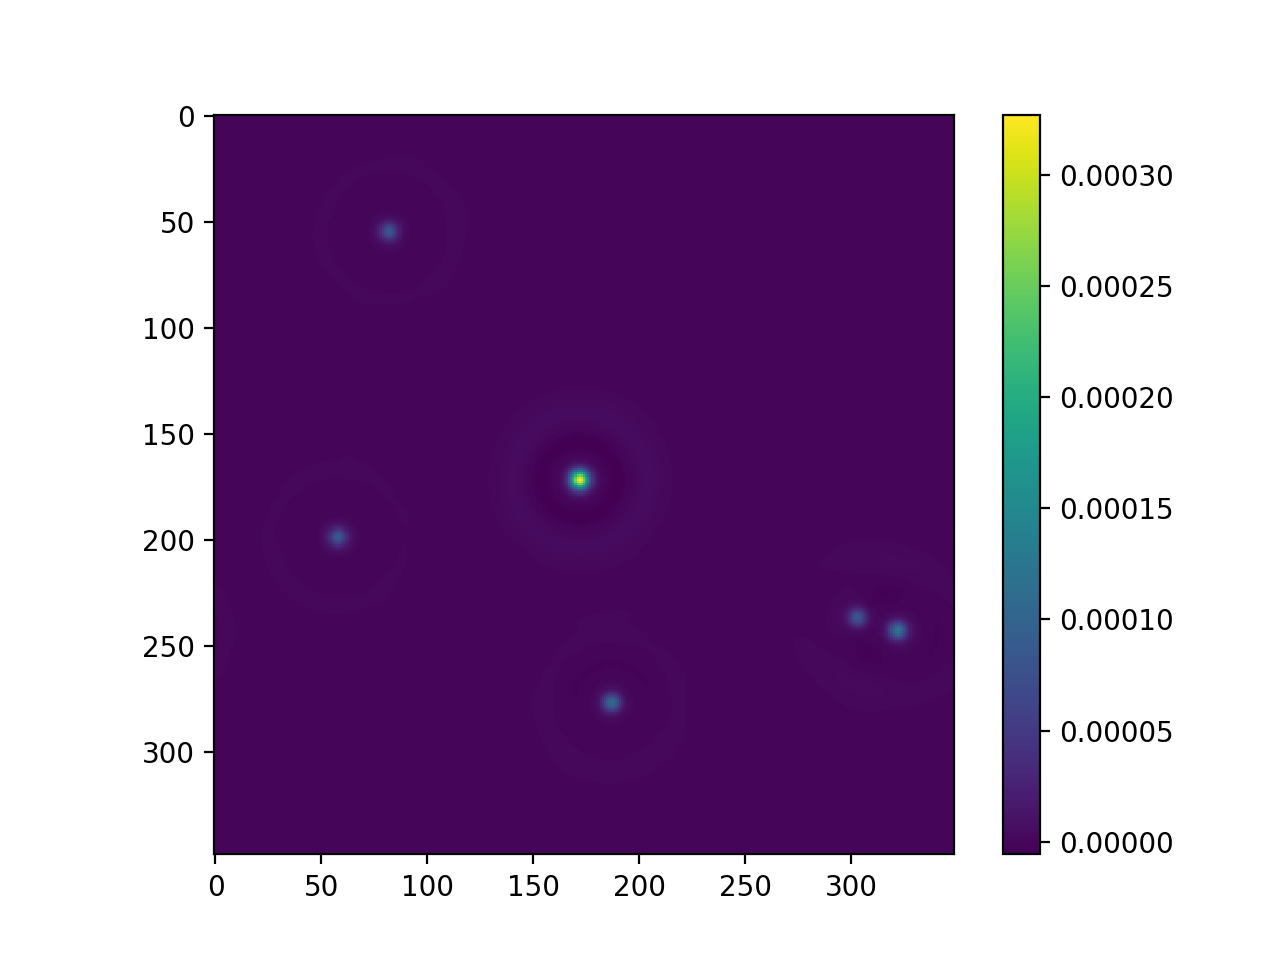

In [98]:
idx=60

pmmf.emask=ymsr.gm.return_edge_apodized_mask(15.,20.)
fdata,err,fdatar=pmmf.return_cluster_catalogue(idx)
print max((fdata*pmmf.cmask).ravel()),err

figure()
imshow(fdata-fdatar)
colorbar()

# MMF analysis with X-ray prior on location, size and temperature of cluster

In [35]:
# pmmf.emask[:,:]=1.
# start=time.time()
# result=parallel_eval_Y500_xray_prior(8)
# print time.time()-start

# filename="ysz_cat_xrayprior_no_edge_mask.fits"
# fxsz_cat=ymsr.write_catalogue(result,filename=filename)


pmmf.emask[:,:]=ymsr.gm.return_edge_apodized_mask(15.,20.)
start=time.time()
result=parallel_eval_Y500_xray_prior(8)
print time.time()-start

filename="ysz_cat_xrayprior_apo_edge_mask.fits"
fxsz_cat=ymsr.write_catalogue(result,filename=filename)

124.91455102


In [5]:
filename="../results/planck_pr1/planck_cosmo_cat/results/10deg_patches/data/ysz_cat_with_rsz_correction.fits"
fxsz_cat=ymsr.read_catalogue(filename=filename)

# MMF analysis with X-ray prior on location, size and temperature of cluster - iterative noise estimation

In [ ]:
pmmf.emask[:,:]=ymsr.gm.return_edge_apodized_mask(15.,20.)
start=time.time()
result=parallel_eval_Y500_xray_prior_iterative(8)
print time.time()-start

filename="ysz_cat_xrayprior_iterative_apo_edge_mask.fits"
fixsz_cat=ymsr.write_catalogue(result)

# Blind MMF analysis

In [51]:
pmmf.emask[:,:]=1.
start=time.time()
bresult=parallel_eval_Y500_blind(8)
print time.time()-start

filename="ysz_cat_blind_iterative_apo_edge_mask.fits"
bxsz_cat=ymsr.write_catalogue(result)

266.39093399


# Results xray priors

## Figures for null tests

<IPython.core.display.Javascript object>


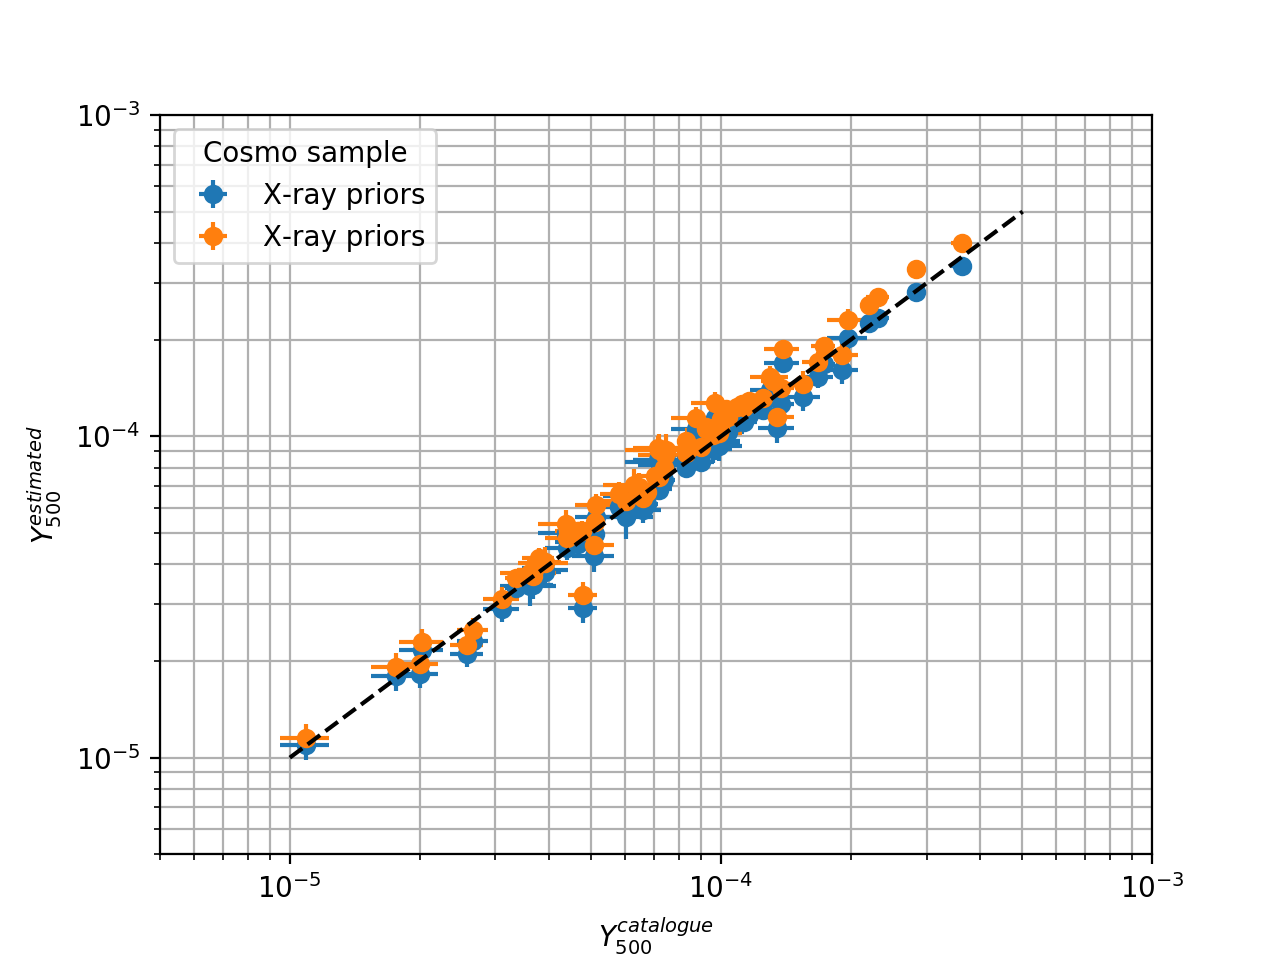

In [94]:
x=logspace(-5,-3.3,100)
figure()
lbl="X-ray priors"
#errorbar(xsz_cat["YSZ_500"],fxsz_cat["YSZ_500"]*corr,xerr=xsz_cat["YSZ_500_err"],yerr=fxsz_cat["YSZ_500_err"],fmt="o",label=lbl)
# lbl="Blind"
errorbar(xsz_cat["YSZ_500"],fxsz_cat["YSZ_500"],xerr=xsz_cat["YSZ_500_err"],yerr=fxsz_cat["YSZ_500_err"],fmt="o",label=lbl)
errorbar(xsz_cat["YSZ_500"],fxsz_cat["YSZ_500_Tc"],xerr=xsz_cat["YSZ_500_err"],yerr=fxsz_cat["YSZ_500_err_Tc"],fmt="o",label=lbl)


#errorbar(xsz_cat["YSZ_500"],bxsz_cat["YSZ_500"],xerr=xsz_cat["YSZ_500_err"],yerr=bxsz_cat["YSZ_500_err"],fmt="o",label=lbl)


plot(x,x,"k--",zorder=10)
grid(which="both")
xlabel("$Y^{catalogue}_{500}$",fontsize=10)
ylabel("$Y^{estimated}_{500}$",fontsize=10)
loglog()
ylim(5e-6,1e-3)
xlim(5e-6,1e-3)
legend(loc=0,title="Cosmo sample")
figname=figpath + "compare_Y500.pdf"
savefig(figname,bbox_inches="tight")

<IPython.core.display.Javascript object>


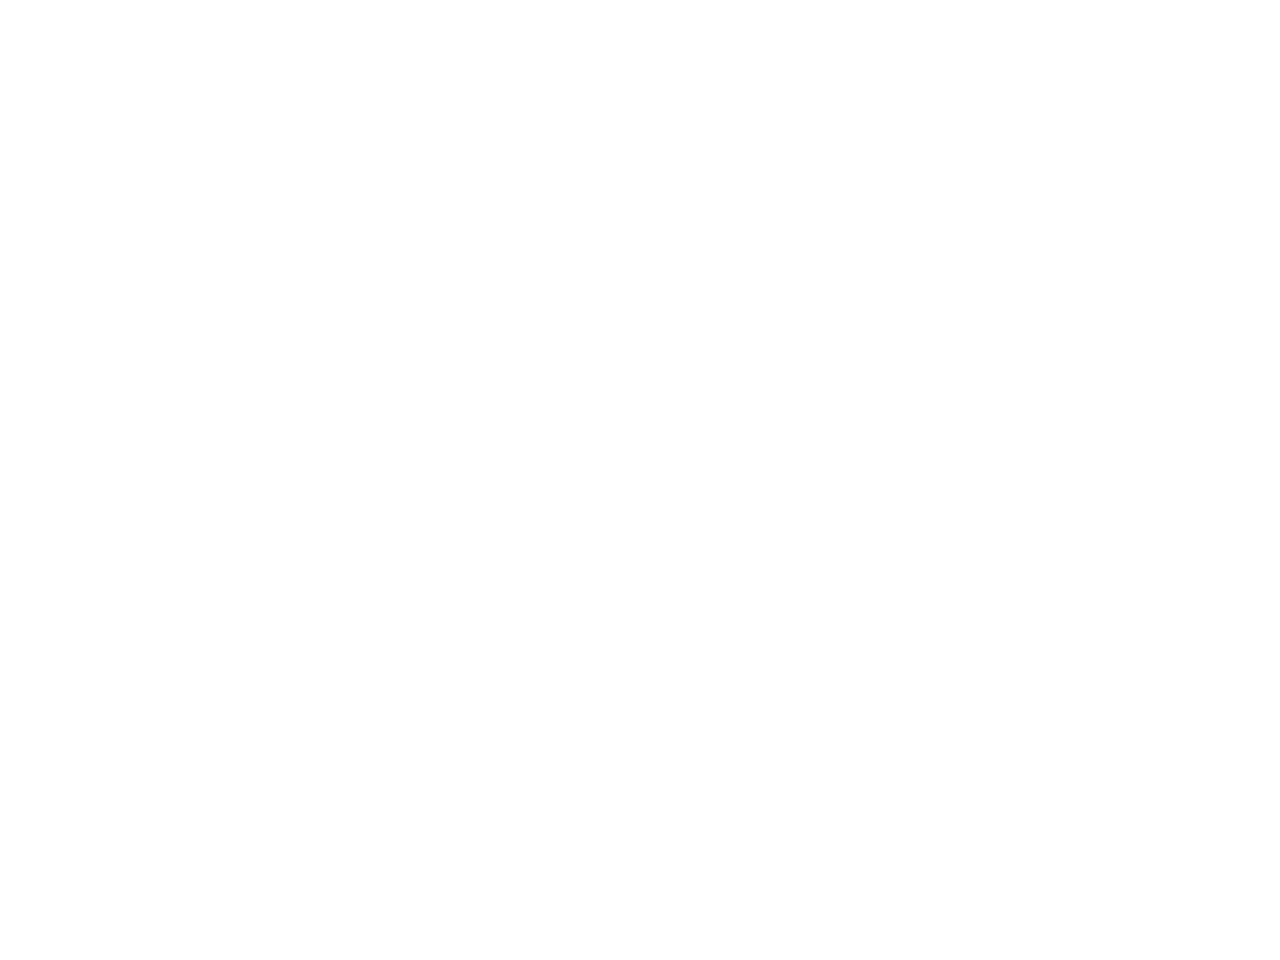

NameError: name 'qblind' is not defined

In [26]:
figure()
qcat=xsz_cat["YSZ_500"]/xsz_cat["YSZ_500_err"]
#qblind=bxsz_cat["YSZ_500"]/bxsz_cat["YSZ_500_err"]
qprior=fxsz_cat["YSZ_500"]/fxsz_cat["YSZ_500_err"]
scatter(xsz_cat["theta500"],qblind/qprior,c=xsz_cat["z"])
colorbar(label="redshift")
#scatter(xsz_cat["theta500"],qcat/qprior)
ylabel(r"$q_{blind} / q_{x-ray}$")
xlabel(r"$\theta_{500}$ arcminutes")
grid(ls="--")

axhline(1,c="k",ls="--")
savefig(figpath + "qblind_vs_qxray_prior.pdf",bbox_inches="tight" )

# x=linspace(5,25,1000)
# plot(x,x,"k--")
#plot(fxsz_cat["YSZ_500"]/fxsz_cat["YSZ_500_err"],"r--")

figure()
scatter(xsz_cat["theta500"],qcat/qprior)

In [78]:
xsz_cat["M500"]

array([  9.81099987,   8.06400013,   5.30299997,   5.63700008,
         6.32800007,   9.09799957,   8.25      ,  10.67000008,
         7.38100004,   5.37200022,   5.91499996,   5.67200041,
         8.0710001 ,   6.61000013,   5.02300024,   5.36100006,
         8.30800056,   6.23500013,   6.40500021,   6.86199999,
         3.91499996,   6.99100018,   7.80499983,  13.92000008,
         8.61299992,   7.54000044,   4.21199989,   4.5079999 ,
         8.19099998,   3.73000002,   5.63599968,   3.99099994,
        12.65999985,  11.62000084,   4.99900007,   3.88499999,
         4.91599989,   5.01399994,   3.64299989,   7.31099987,
         7.38000011,  10.75999928,   4.78200006,   5.95600033,
         8.3029995 ,   5.45200014,   5.29500008,   4.7750001 ,
         6.10899973,   3.67499971,   4.29100037,   3.66400003,
         8.68599987,   7.50699997,   2.39400005,   2.7019999 ,
         3.1559999 ,   4.12099981,   7.21899986,   5.13600016,
         8.47100067,   7.13000011,   6.329     ,   4.72

# Difference statistics

In [60]:
# statdiff=(xsz_cat["YSZ_500"]-fxsz_cat["YSZ_500"])/xsz_cat["YSZ_500"]
# diffidx=np.where(abs(statdiff)>=0.05)[0]

# figure()
# plot(statdiff)
# plot(diffidx,statdiff[diffidx],"o")
# #axhline(1.,c="k",ls="--")
# #axhline(-1.,c="k",ls="--")

# figure()
# x=logspace(-5,-3.3,100)
# lbl="X-ray priors"
# errorbar(xsz_cat["YSZ_500"][diffidx],fxsz_cat["YSZ_500"][diffidx],xerr=xsz_cat["YSZ_500_err"][diffidx],yerr=fxsz_cat["YSZ_500_err"][diffidx],fmt="o",label=lbl)
# plot(x,x,"k--",zorder=10)

<IPython.core.display.Javascript object>


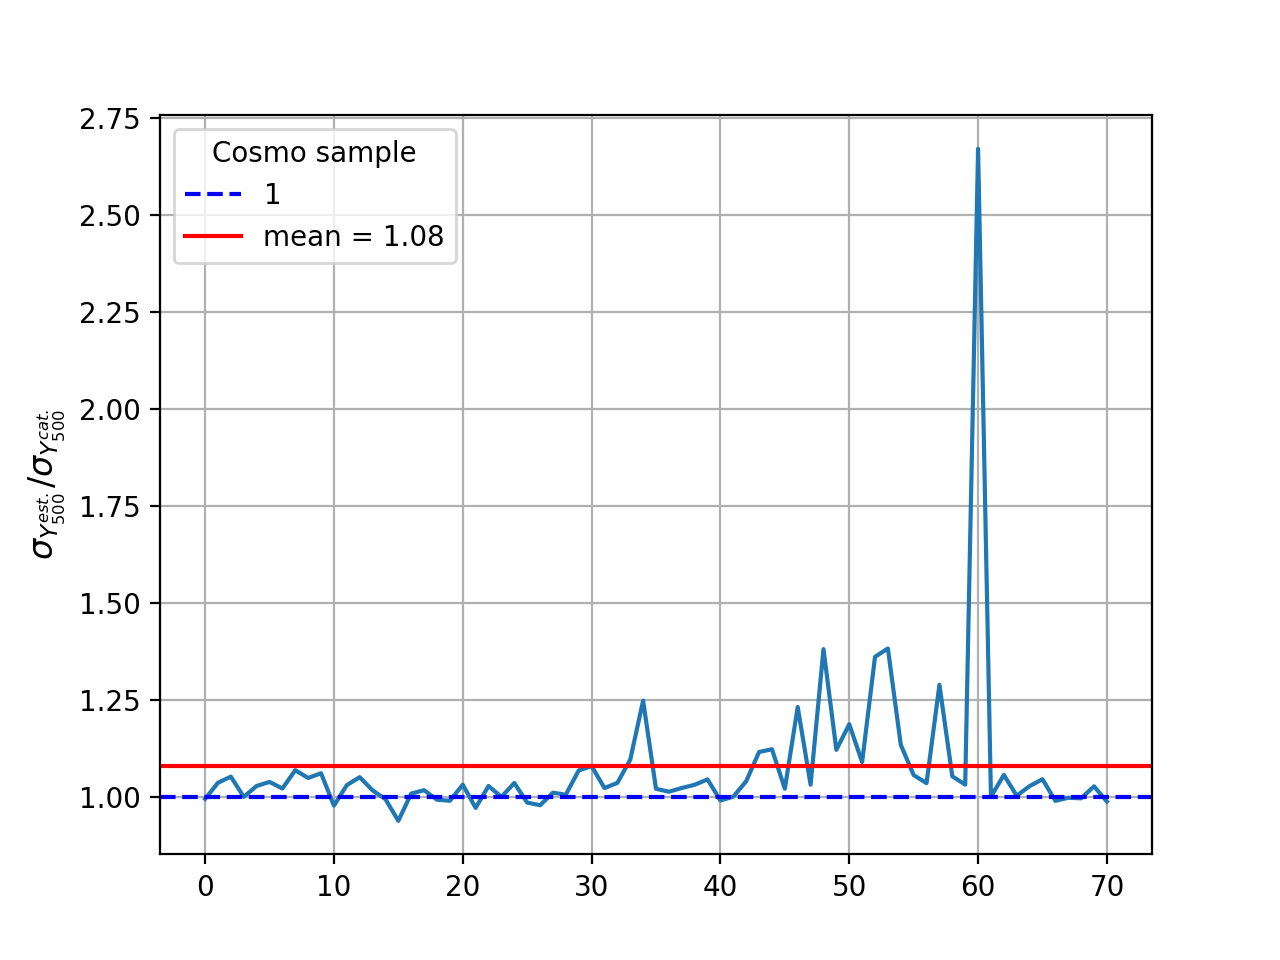

In [24]:
figure()
plot(fxsz_cat["YSZ_500_err"]/xsz_cat["YSZ_500_err"])
#axhline(1,ls="--",c="k")
axhline(1.,ls="--",c="b",label="$1$")
mu=mean(np.array(fxsz_cat["YSZ_500_err"]/xsz_cat["YSZ_500_err"]))
axhline(mu,label="mean = "+ str(round(mu,3)),c="r")
legend(loc=0,title="Cosmo sample")
ylabel("$\sigma_{Y^{est.}_{500}}/\sigma_{Y^{cat.}_{500}}$",fontsize=12)
grid()
figname=figpath + "compare_Y500_err.pdf"
savefig(figname,bbox_inches="tight")

<IPython.core.display.Javascript object>


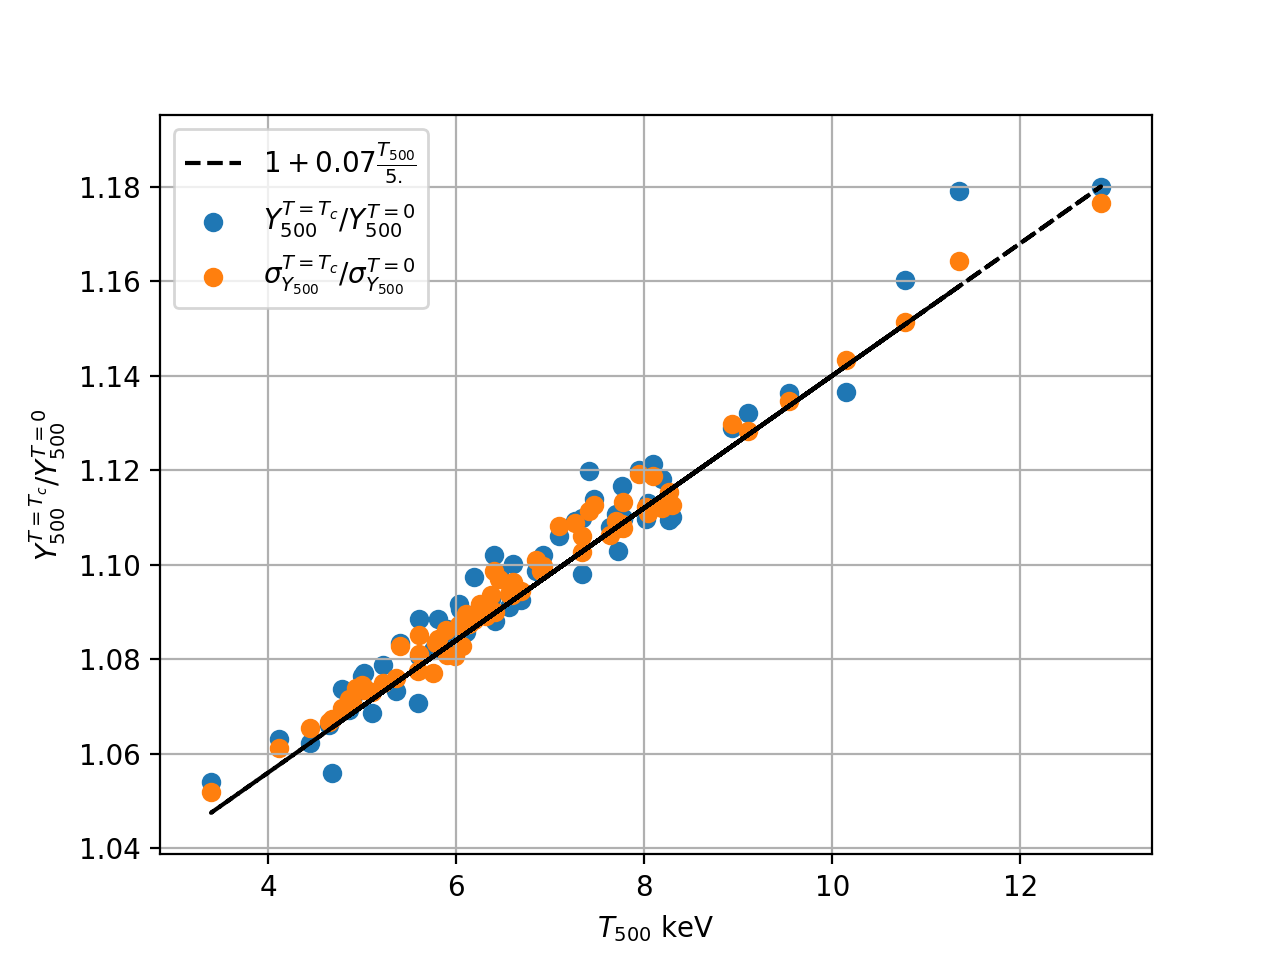

<IPython.core.display.Javascript object>


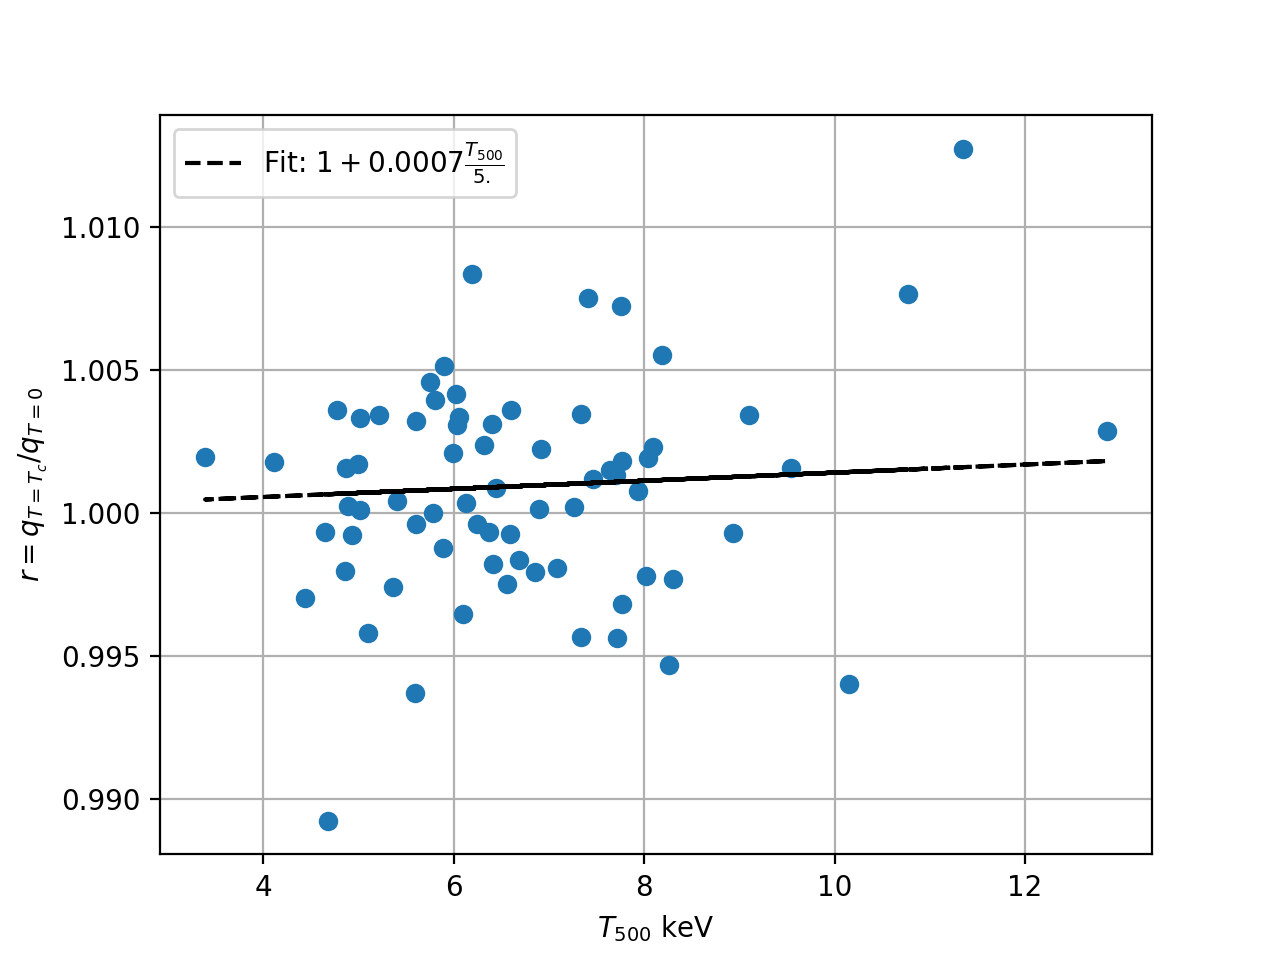

In [37]:
figure()
scatter(xsz_cat["T500"],fxsz_cat["YSZ_500_Tc"]/fxsz_cat["YSZ_500"],label="$Y^{T=T_c}_{500}/Y^{T=0}_{500}$")
scatter(xsz_cat["T500"],fxsz_cat["YSZ_500_err_Tc"]/fxsz_cat["YSZ_500_err"],label="$\sigma^{T=T_c}_{Y_{500}}/\sigma^{T=0}_{Y_{500}}$")
plot(xsz_cat["T500"],1+0.07*xsz_cat["T500"]/5.,"k--",label=r"$1 + 0.07 \frac{T_{500}}{5.}$")
xlabel('$T_{500}$ keV')
ylabel('$Y^{T=T_c}_{500}/Y^{T=0}_{500}$')
grid()
legend(loc=0)
figname=figpath + "Y500_T0_vs_Y500_Tc.pdf"
savefig(figname,bbox_inches="tight")



# Ratio of SNR
qTT=fxsz_cat["YSZ_500_Tc"]/fxsz_cat["YSZ_500_err_Tc"]
qT0=fxsz_cat["YSZ_500"]/fxsz_cat["YSZ_500_err"]

fn=lambda x,a: 1.+a*x/5.
slope,slope_err=curve_fit(fn,xsz_cat["T500"],qTT/qT0)

figure()
plot(xsz_cat["T500"],qTT/qT0,"o")
#plot(xsz_cat["T500"],1+0.07*xsz_cat["T500"]/5.,"r-",label=r"$1 + 0.07 \frac{T_{500}}{5.}$")
plot(xsz_cat["T500"],fn(xsz_cat["T500"],slope),"k--",label="Fit: " + "$1 + $" + str(round(slope,4)) + r"$\frac{T_{500}}{5.}$")
xlabel('$T_{500}$ keV')
ylabel('$r=q_{T=T_c}/q_{T=0}$')
grid()
legend(loc=0)
figname=figpath + "SNR_qT0_qTT.pdf"

In [39]:
mean(qTT)-mean(qT0)

0.014678700068490258

## Deriving $Y^{SZ}_{500} - Y^X_{500}$ scalinng law

In [11]:
# xdata=log10(xsz_cat["YX_500"]/1e-4)
# xerr=return_log_err(xsz_cat["YX_500"]/1e-4,xsz_cat["YX_500_err"]/1e-4)

# # Catalogue
# ydata=log10(xsz_cat["YSZ_500"])
# yerr=return_log_err(xsz_cat["YSZ_500"],xsz_cat["YSZ_500_err"])
# acat,bcat,erracat,errbcat,covab=bces.bcesp(xdata,xerr,ydata,yerr,np.zeros_like(xdata),100000)
# print acat[3],erracat[3],bcat[3],errbcat[3]


# # T=0
# ydata=log10(fxsz_cat["YSZ_500"])
# yerr=return_log_err(fxsz_cat["YSZ_500"],fxsz_cat["YSZ_500_err"])
# aT0,bT0,erraT0,errbT0,covab=bces.bcesp(xdata,xerr,ydata,yerr,np.zeros_like(xdata),100000)
# print aT0[3],erraT0[3],bT0[3],errbT0[3]

# # T=T_c
# ydata=log10(fxsz_cat["YSZ_500_Tc"])
# yerr=return_log_err(fxsz_cat["YSZ_500_Tc"],fxsz_cat["YSZ_500_err_Tc"])
# aTT,bTT,erraTT,errbTT,covab=bces.bcesp(xdata,xerr,ydata,yerr,np.zeros_like(xdata),100000)
# print aTT[3],erraTT[3],bTT[3],errbTT[3]

In [12]:
# figure()
# errorbar(xsz_cat["YX_500"],xsz_cat["YSZ_500"],xerr=xsz_cat["YX_500_err"],yerr=xsz_cat["YSZ_500_err"],fmt='o',ms=5,label="Catalogue")
# errorbar(xsz_cat["YX_500"]+0.02*xsz_cat["YX_500"],fxsz_cat["YSZ_500"],xerr=xsz_cat["YX_500_err"],yerr=fxsz_cat["YSZ_500_err"],fmt='o',ms=5,label="Estimated $(T=0)$")
# tempx=linspace(5e-6,5e-3,1000)
# lbl="$A_{cat}$ = " + str(round(bcat[3],2)) + "$\pm$" + str(round(errbcat[3],3)) 
# lbl=lbl + " ; $B_{cat}$ = " +str(round(acat[3],2))  + "$\pm$" + str(round(erracat[3],3))
# plot(tempx,(10.**bcat[3])*(tempx/1e-4)**acat[3],label=lbl,zorder=1)

# lbl="$A_{T=0}$ = " + str(round(bT0[3],2)) + "$\pm$" + str(round(errbT0[3],3)) 
# lbl=lbl + " ; $B_{T=0}$ = " +str(round(aT0[3],2))  + "$\pm$" + str(round(erraT0[3],3))
# plot(tempx,(10.**bT0[3])*(tempx/1e-4)**aT0[3],label=lbl,zorder=3)
# ylim(5e-6,1e-3)
# xlim(5e-6,1e-3)
# loglog()
# legend(loc=0)
# ylabel("$Y^{SZ}_{500}$",fontsize=10)
# xlabel("$Y^X_{500}$",fontsize=10)
# grid(which="both",alpha=0.4)
# figname=figpath + "YSZ500_YX500_cat_vs_est.pdf"
# savefig(figname,bbox_inches="tight")

In [13]:
# figure()
# errorbar(xsz_cat["YX_500"],fxsz_cat["YSZ_500"],xerr=xsz_cat["YX_500_err"],yerr=fxsz_cat["YSZ_500_err"],fmt='o',ms=5,label="Estimated $(T=0)$")
# errorbar(xsz_cat["YX_500"],fxsz_cat["YSZ_500_Tc"],xerr=xsz_cat["YX_500_err"],yerr=fxsz_cat["YSZ_500_err_Tc"],fmt='o',ms=5,label="Estimated $(T=T_c)$")
# tempx=linspace(5e-6,5e-3,1000)
# lbl="$A_{T=0}$ = " + str(round(bT0[3],2)) + "$\pm$" + str(round(errbT0[3],3)) 
# lbl=lbl + " ; $B_{T=0}$ = " +str(round(aT0[3],2))  + "$\pm$" + str(round(erraT0[3],3))
# plot(tempx,(10.**bT0[3])*(tempx/1e-4)**aT0[3],label=lbl,zorder=3)

# lbl="$A_{T=T_c}$ = " + str(round(bTT[3],2)) + "$\pm$" + str(round(errbTT[3],3)) 
# lbl=lbl + " ; $B_{T=T_c}$ = " +str(round(aTT[3],2))  + "$\pm$" + str(round(erraTT[3],3))
# plot(tempx,(10.**bTT[3])*(tempx/1e-4)**aTT[3],label=lbl,zorder=5)

# ylim(5e-6,1e-3)
# xlim(5e-6,1e-3)
# loglog()
# legend(loc=0)
# ylabel("$Y^{SZ}_{500}$",fontsize=10)
# xlabel("$Y^X_{500}$",fontsize=10)
# grid(which="both",alpha=0.4)
# figname=figpath + "YSZ500_YX500_T0_vs_TT.pdf"
# savefig(figname,bbox_inches="tight")

## Deriving $Y^{SZ}_{500} - M^X_{500}$ scalinng law

In [48]:
# # This produces numbers in row 2 of Table 2 from Planck early results XI (A&A 536 A11 2011)
# Ezgamma=cosmo_fn.Ez(xsz_cat["z"])**(-2./3.)
# This produces numbers in Table A.1 from Planck Collaboration: Cosmology from SZ cluster counts (2013)
Ezgamma=(cosmo_fn.Ez(xsz_cat["z"])**(-2./3.))/1e-4
Ezgamma=Ezgamma/xsz_cat["BIAS"]

xdata=log10(xsz_cat["M500"]/6.)
xerr=return_log_err(xsz_cat["M500"]/6.,xsz_cat["M500_err"]/6.)

# Catalogue
ydata=log10(xsz_cat["YSZ_500"]*Ezgamma)
yerr=return_log_err(xsz_cat["YSZ_500"]*Ezgamma,fxsz_cat["YSZ_500_err"]*Ezgamma)
acat,bcat,erracat,errbcat,covab=bces.bcesp(xdata,xerr,ydata,yerr,np.zeros_like(xdata),100000)
print acat[3],erracat[3],bcat[3],errbcat[3]


# T=0
ydata=log10(fxsz_cat["YSZ_500"]*Ezgamma)
yerr=return_log_err(fxsz_cat["YSZ_500"]*Ezgamma,fxsz_cat["YSZ_500_err"]*Ezgamma)
aT0,bT0,erraT0,errbT0,covab=bces.bcesp(xdata,xerr,ydata,yerr,np.zeros_like(xdata),100000)
print aT0[3],erraT0[3],bT0[3],errbT0[3]

# T=T_c
ydata=log10(fxsz_cat["YSZ_500_Tc"]*Ezgamma)
yerr=return_log_err(fxsz_cat["YSZ_500_Tc"]*Ezgamma,fxsz_cat["YSZ_500_err_Tc"]*Ezgamma)

aTT,bTT,erraTT,errbTT,covab=bces.bcesp(xdata,xerr,ydata,yerr,np.zeros_like(xdata),100000)
print aTT[3],erraTT[3],bTT[3],errbTT[3]

BCES, 100000 trials... 
15.254185 s
1.78036738416 0.0632231206501 -0.185729230249 0.0105494958554
BCES, 100000 trials... 
15.200389 s
1.79254703186 0.0700611465453 -0.179494759636 0.0114039966172
BCES, 100000 trials... 
15.202776 s
1.83724687154 0.0663282529246 -0.139353975689 0.0111115671445


<IPython.core.display.Javascript object>


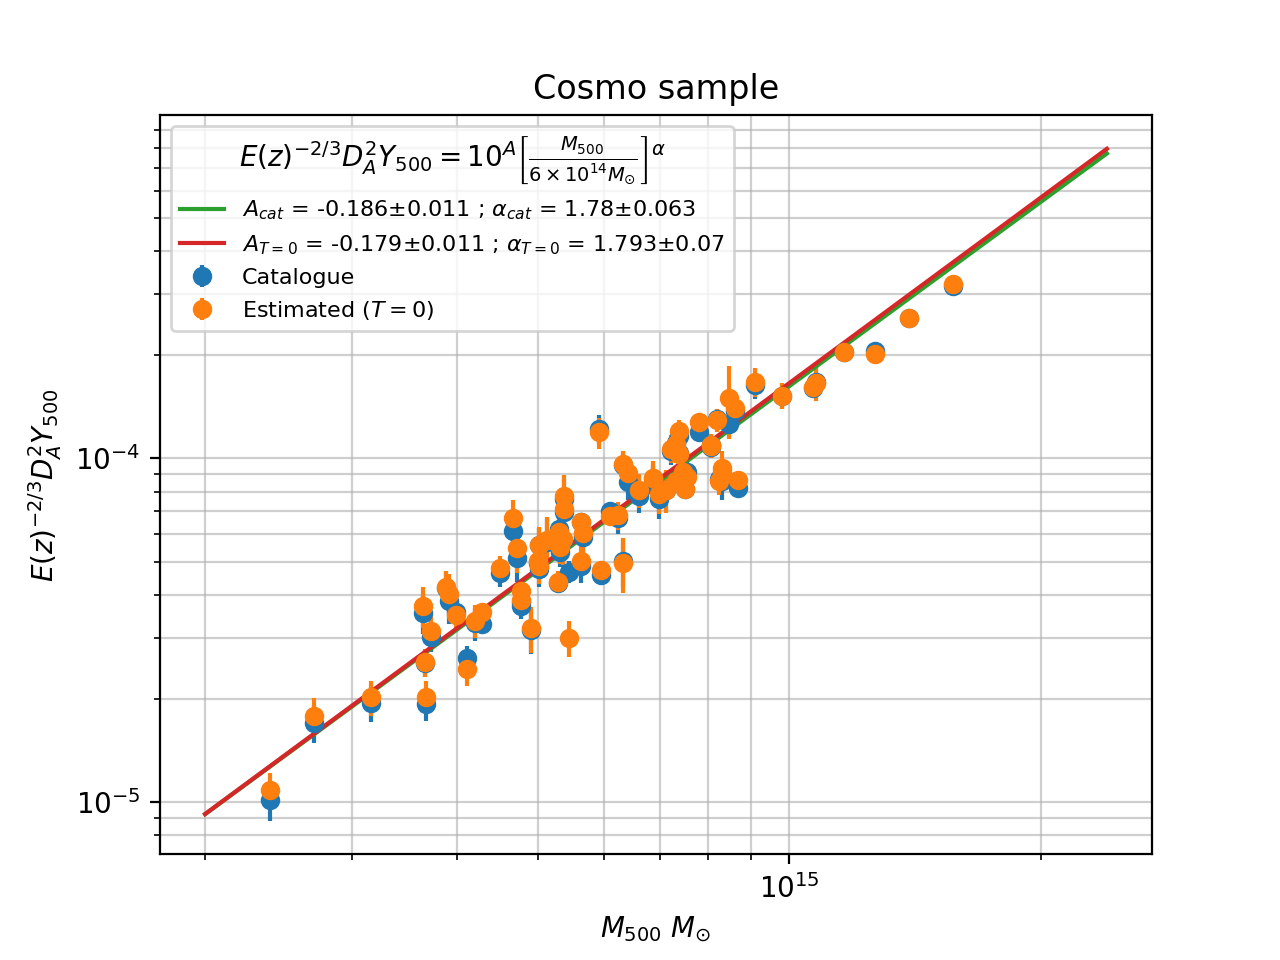

In [49]:
M500=linspace(2,24,1000)
norm=1e-4
figure()
errorbar(xsz_cat["M500"]*1e14,Ezgamma*xsz_cat["YSZ_500"]*norm,yerr=xsz_cat["YSZ_500_err"]*Ezgamma*norm,fmt="o",label="Catalogue")
errorbar(xsz_cat["M500"]*1e14,Ezgamma*fxsz_cat["YSZ_500"]*norm,yerr=fxsz_cat["YSZ_500_err"]*Ezgamma*norm,fmt="o",label="Estimated $(T=0)$")

lbl=r"$A_{cat}$ = " + str(round(bcat[3],3)) + r"$\pm$" + str(round(errbcat[3],3)) 
lbl=lbl + r" ; $\alpha_{cat}$ = " +str(round(acat[3],3))  + r"$\pm$" + str(round(erracat[3],3))
plot(M500*1e14,(10.**bcat[3])*((M500/6.)**acat[3])*norm,label=lbl)

lbl=r"$A_{T=0}$ = " + str(round(bT0[3],3)) + "$\pm$" + str(round(errbT0[3],3)) 
lbl=lbl + r" ; $\alpha_{T=0}$ = " +str(round(aT0[3],3))  + "$\pm$" + str(round(erraT0[3],3))
plot(M500*1e14,(10.**bT0[3])*((M500/6.)**aT0[3])*norm,label=lbl)

ylabel(r"$E(z)^{-2/3} D^2_A Y_{500}$")
xlabel(r"$M_{500}$" + " " + "$M_{\odot}$")
lbl=r"$E(z)^{-2/3} D^2_A Y_{500} = 10^A \left[ \frac{M_{500}}{6 \times 10^{14} M_{\odot}}\right]^\alpha$"
legend(loc=0,title=lbl,fontsize=8)
title("Cosmo sample")
loglog()
grid(which="both",alpha=0.6)
figname=figpath + "Y500_vs_M500_compare_with_cat.pdf"
savefig(figname,bbox_inches="tight")

<IPython.core.display.Javascript object>


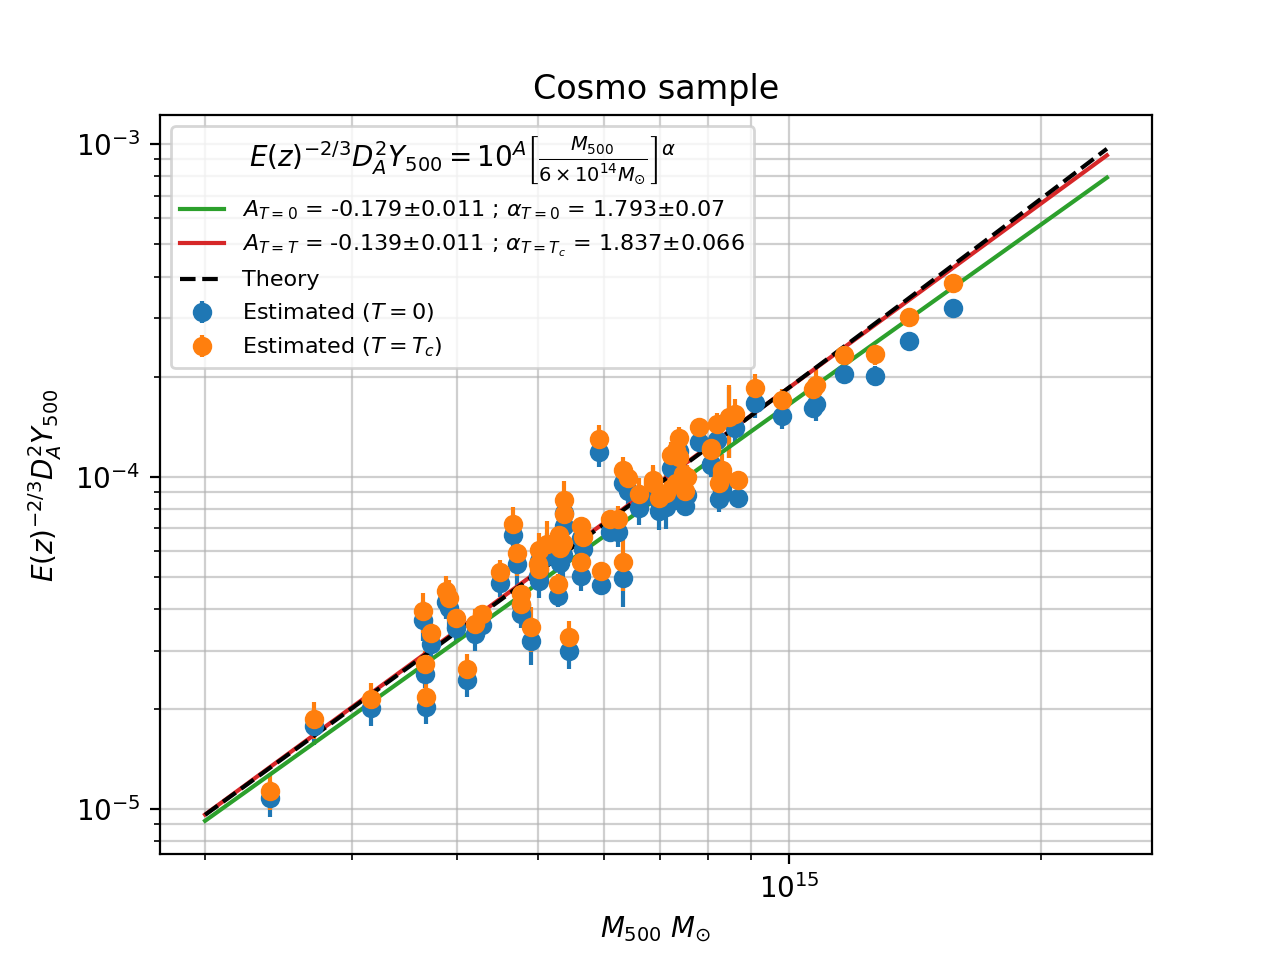

In [50]:
M500=linspace(2,24,1000)
T500=cosmo_fn.convert_M500_T500(M500,0.)
correction=1+0.07*(T500/5.)

norm=1e-4
figure()
errorbar(xsz_cat["M500"]*1e14,Ezgamma*fxsz_cat["YSZ_500"]*norm,yerr=fxsz_cat["YSZ_500_err"]*Ezgamma*norm,fmt="o",label="Estimated $(T=0)$")
errorbar(xsz_cat["M500"]*1e14,Ezgamma*fxsz_cat["YSZ_500_Tc"]*norm,yerr=fxsz_cat["YSZ_500_err_Tc"]*Ezgamma*norm,fmt="o",label="Estimated $(T=T_c)$")

lbl=r"$A_{T=0}$ = " + str(round(bT0[3],3)) + "$\pm$" + str(round(errbT0[3],3)) 
lbl=lbl + r" ; $\alpha_{T=0}$ = " +str(round(aT0[3],3))  + "$\pm$" + str(round(erraT0[3],3))
plot(M500*1e14,(10.**bT0[3])*((M500/6.)**aT0[3])*norm,label=lbl)

lbl=r"$A_{T=T}$ = " + str(round(bTT[3],3)) + r"$\pm$" + str(round(errbTT[3],3)) 
lbl=lbl + r" ; $\alpha_{T=T_c}$ = " +str(round(aTT[3],3))  + r"$\pm$" + str(round(erraTT[3],3))
plot(M500*1e14,(10.**bTT[3])*((M500/6.)**aTT[3])*norm,label=lbl)

plot(M500*1e14,(10.**bT0[3])*((M500/6.)**aT0[3])*norm*correction,"k--",label="Theory")

ylabel(r"$E(z)^{-2/3} D^2_A Y_{500}$")
xlabel(r"$M_{500}$" + " " + "$M_{\odot}$")
lbl=r"$E(z)^{-2/3} D^2_A Y_{500} = 10^A \left[ \frac{M_{500}}{6 \times 10^{14} M_{\odot}}\right]^\alpha$"
legend(loc=0,title=lbl,fontsize=8)
loglog()
title("Cosmo sample")
grid(which="both",alpha=0.6)
figname=figpath + "Y500_vs_M500_rSZ_correction.pdf"
savefig(figname,bbox_inches="tight")

# Blind analysis

<IPython.core.display.Javascript object>


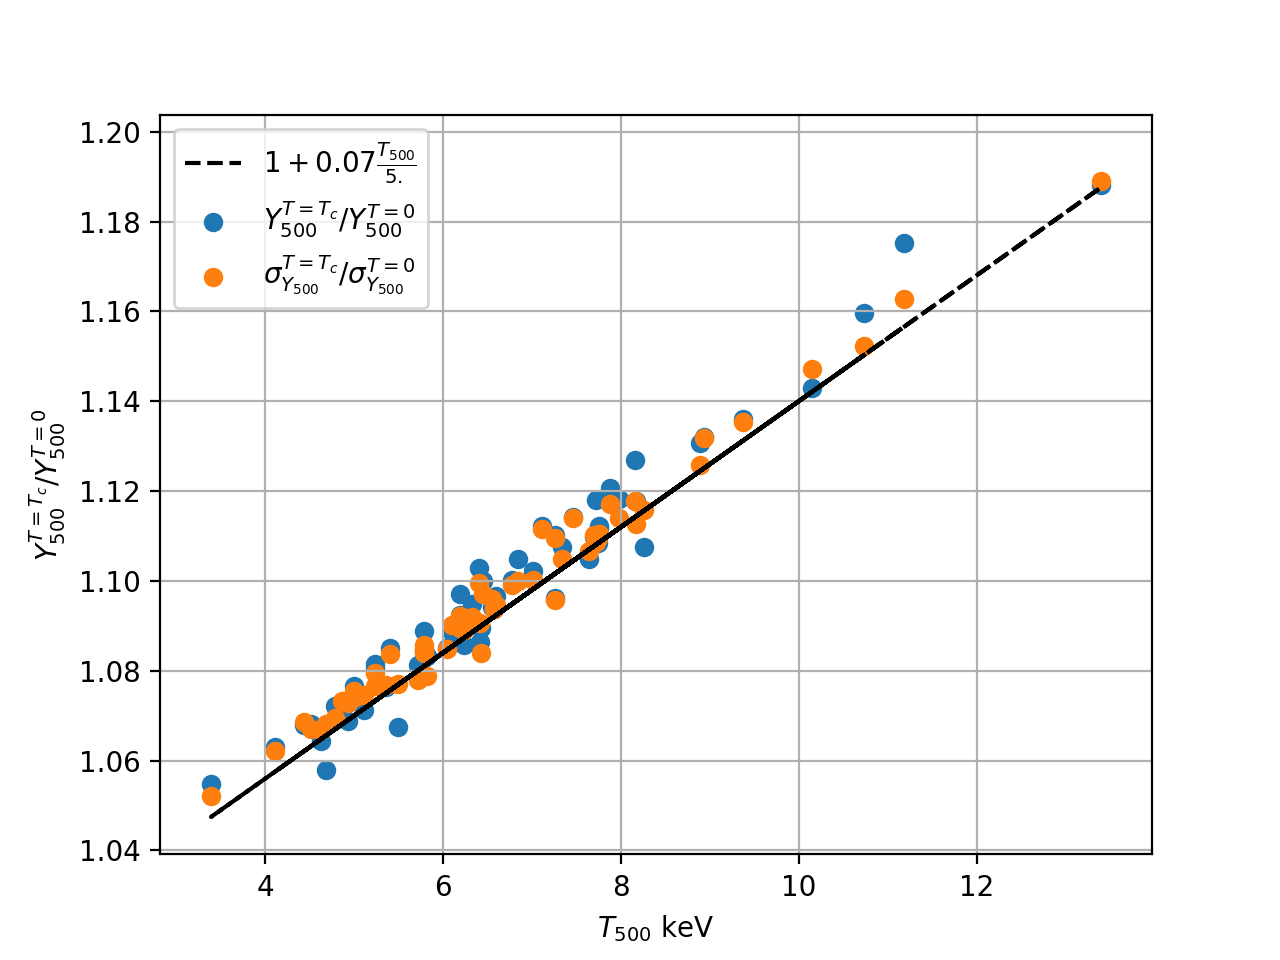

<IPython.core.display.Javascript object>


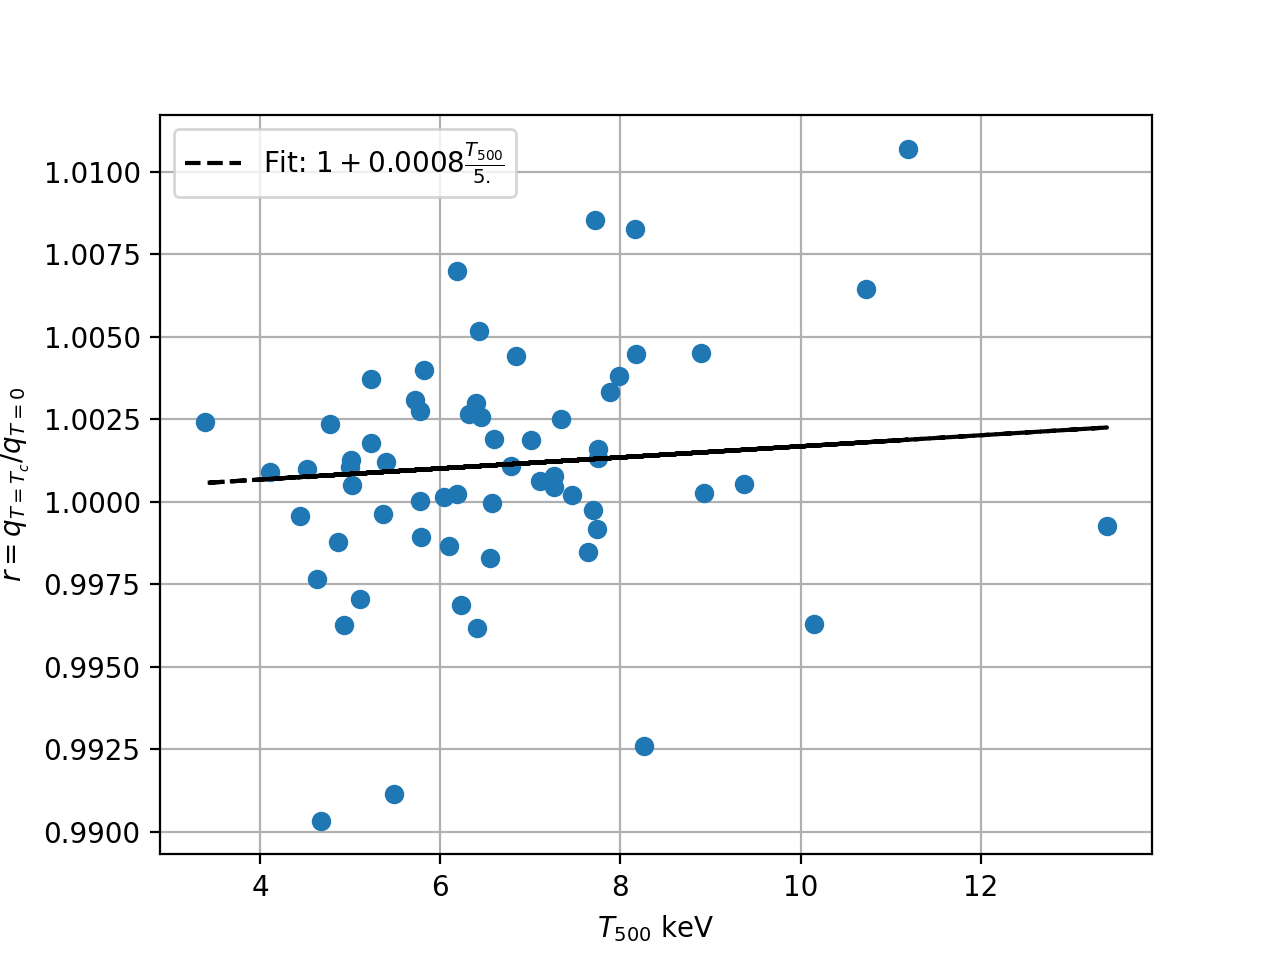

In [14]:
figure()
scatter(xsz_cat["T500"],bxsz_cat["YSZ_500_Tc"]/bxsz_cat["YSZ_500"],label="$Y^{T=T_c}_{500}/Y^{T=0}_{500}$")
scatter(xsz_cat["T500"],bxsz_cat["YSZ_500_err_Tc"]/bxsz_cat["YSZ_500_err"],label="$\sigma^{T=T_c}_{Y_{500}}/\sigma^{T=0}_{Y_{500}}$")
plot(xsz_cat["T500"],1+0.07*xsz_cat["T500"]/5.,"k--",label=r"$1 + 0.07 \frac{T_{500}}{5.}$")
xlabel('$T_{500}$ keV')
ylabel('$Y^{T=T_c}_{500}/Y^{T=0}_{500}$')
grid()
legend(loc=0)
figname=figpath + "Y500_T0_vs_Y500_Tc.pdf"
savefig(figname,bbox_inches="tight")



# Ratio of SNR
qTT=bxsz_cat["YSZ_500_Tc"]/bxsz_cat["YSZ_500_err_Tc"]
qT0=bxsz_cat["YSZ_500"]/bxsz_cat["YSZ_500_err"]

fn=lambda x,a: 1.+a*x/5.
slope,slope_err=curve_fit(fn,xsz_cat["T500"],qTT/qT0)

figure()
plot(xsz_cat["T500"],qTT/qT0,"o")
#plot(xsz_cat["T500"],1+0.07*xsz_cat["T500"]/5.,"r-",label=r"$1 + 0.07 \frac{T_{500}}{5.}$")
plot(xsz_cat["T500"],fn(xsz_cat["T500"],slope),"k--",label="Fit: " + "$1 + $" + str(round(slope,4)) + r"$\frac{T_{500}}{5.}$")
xlabel('$T_{500}$ keV')
ylabel('$r=q_{T=T_c}/q_{T=0}$')
grid()
legend(loc=0)
figname=figpath + "blind_SNR_qT0_qTT.pdf"

In [15]:
xdata=log10(xsz_cat["YX_500"]/1e-4)
xerr=return_log_err(xsz_cat["YX_500"]/1e-4,xsz_cat["YX_500_err"]/1e-4)

# Catalogue
ydata=log10(xsz_cat["YSZ_500"])
yerr=return_log_err(xsz_cat["YSZ_500"],xsz_cat["YSZ_500_err"])
acat,bcat,erracat,errbcat,covab=bces.bcesp(xdata,xerr,ydata,yerr,np.zeros_like(xdata),100000)
print acat[3],erracat[3],bcat[3],errbcat[3]


# T=0
ydata=log10(bxsz_cat["YSZ_500"])
yerr=return_log_err(bxsz_cat["YSZ_500"],bxsz_cat["YSZ_500_err"])
aT0,bT0,erraT0,errbT0,covab=bces.bcesp(xdata,xerr,ydata,yerr,np.zeros_like(xdata),100000)
print aT0[3],erraT0[3],bT0[3],errbT0[3]

# T=T_c
ydata=log10(bxsz_cat["YSZ_500_Tc"])
yerr=return_log_err(bxsz_cat["YSZ_500_Tc"],bxsz_cat["YSZ_500_err_Tc"])
aTT,bTT,erraTT,errbTT,covab=bces.bcesp(xdata,xerr,ydata,yerr,np.zeros_like(xdata),100000)
print aTT[3],erraTT[3],bTT[3],errbTT[3]

BCES, 100000 trials... 
12.696015 s
0.958002041199 0.0394579095155 -4.02398620022 0.0121770277918
BCES, 100000 trials... 
12.985723 s
0.855558864726 0.0650257072375 -3.96710501878 0.0155333025877
BCES, 100000 trials... 
14.667182 s
0.885158664087 0.0642805169259 -3.92317818401 0.015303569138


<IPython.core.display.Javascript object>


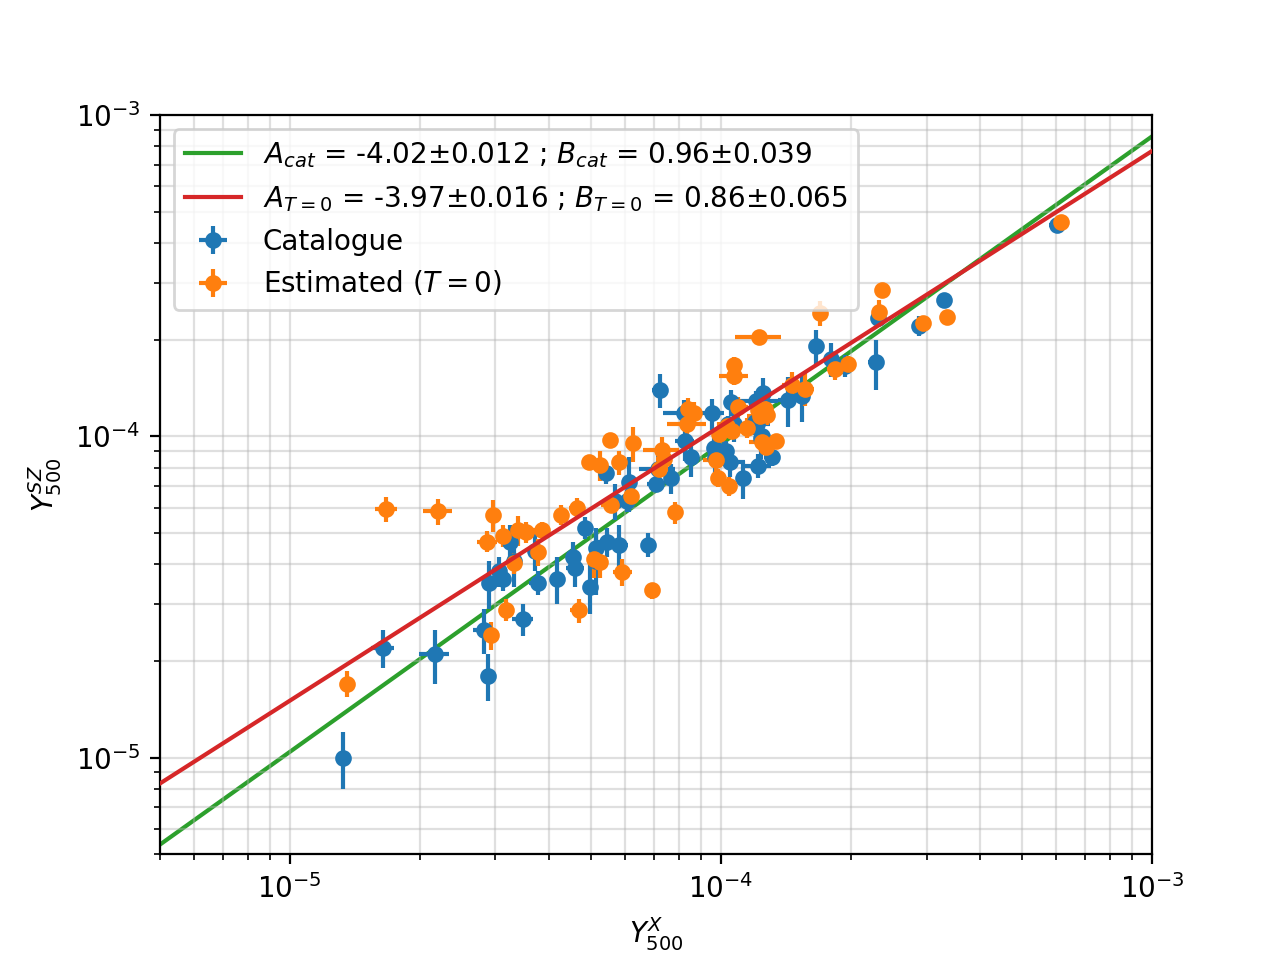

In [16]:
figure()
errorbar(xsz_cat["YX_500"],xsz_cat["YSZ_500"],xerr=xsz_cat["YX_500_err"],yerr=xsz_cat["YSZ_500_err"],fmt='o',ms=5,label="Catalogue")
errorbar(xsz_cat["YX_500"]+0.02*xsz_cat["YX_500"],bxsz_cat["YSZ_500"],xerr=xsz_cat["YX_500_err"],yerr=bxsz_cat["YSZ_500_err"],fmt='o',ms=5,label="Estimated $(T=0)$")
tempx=linspace(5e-6,5e-3,1000)
lbl="$A_{cat}$ = " + str(round(bcat[3],2)) + "$\pm$" + str(round(errbcat[3],3)) 
lbl=lbl + " ; $B_{cat}$ = " +str(round(acat[3],2))  + "$\pm$" + str(round(erracat[3],3))
plot(tempx,(10.**bcat[3])*(tempx/1e-4)**acat[3],label=lbl,zorder=1)

lbl="$A_{T=0}$ = " + str(round(bT0[3],2)) + "$\pm$" + str(round(errbT0[3],3)) 
lbl=lbl + " ; $B_{T=0}$ = " +str(round(aT0[3],2))  + "$\pm$" + str(round(erraT0[3],3))
plot(tempx,(10.**bT0[3])*(tempx/1e-4)**aT0[3],label=lbl,zorder=3)
ylim(5e-6,1e-3)
xlim(5e-6,1e-3)
loglog()
legend(loc=0)
ylabel("$Y^{SZ}_{500}$",fontsize=10)
xlabel("$Y^X_{500}$",fontsize=10)
grid(which="both",alpha=0.4)
figname=figpath + "blind_YSZ500_YX500_cat_vs_est.pdf"
savefig(figname,bbox_inches="tight")

<IPython.core.display.Javascript object>


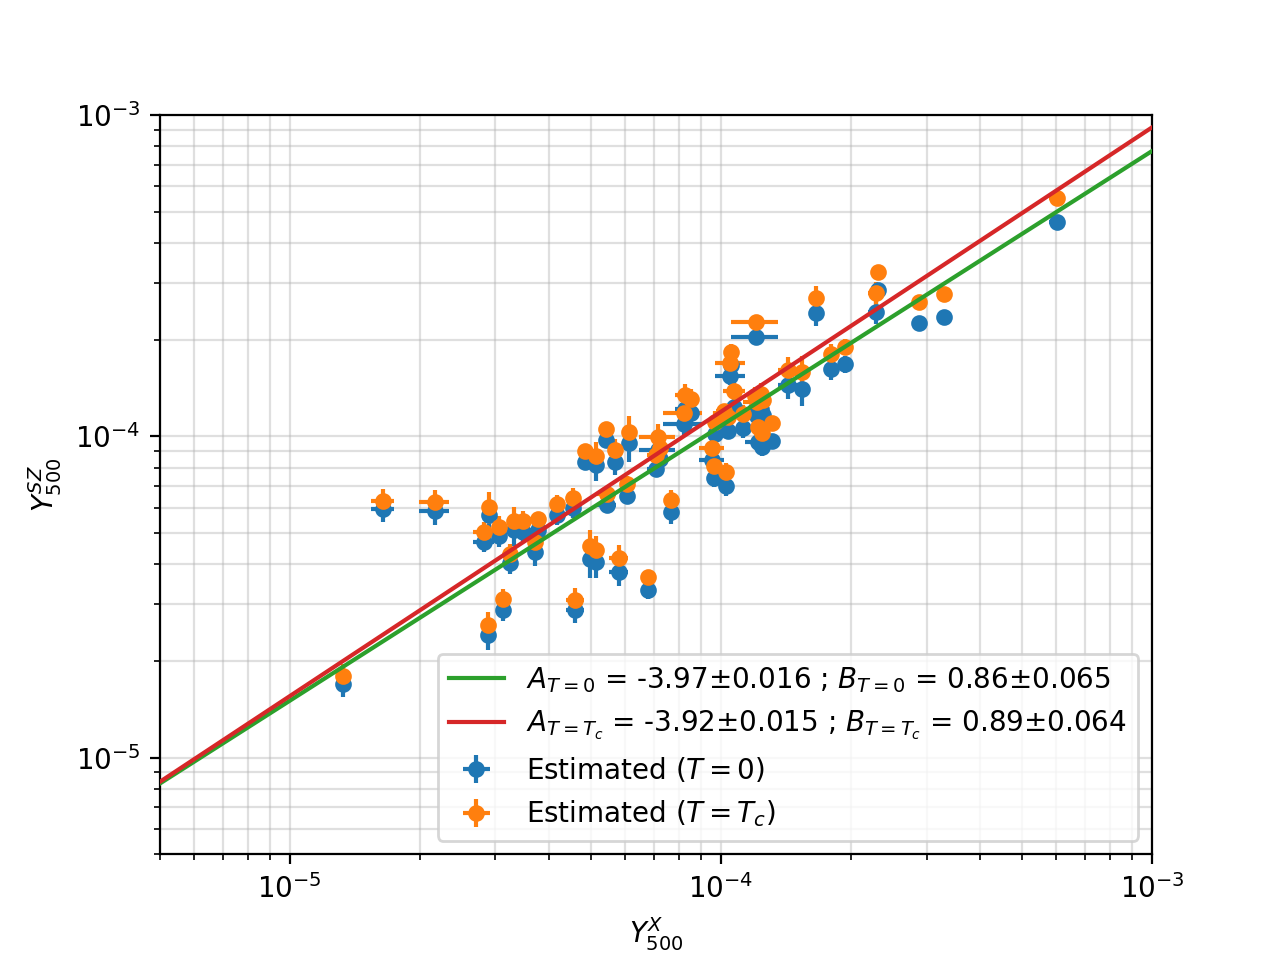

In [17]:
figure()
errorbar(xsz_cat["YX_500"],bxsz_cat["YSZ_500"],xerr=xsz_cat["YX_500_err"],yerr=bxsz_cat["YSZ_500_err"],fmt='o',ms=5,label="Estimated $(T=0)$")
errorbar(xsz_cat["YX_500"],bxsz_cat["YSZ_500_Tc"],xerr=xsz_cat["YX_500_err"],yerr=bxsz_cat["YSZ_500_err_Tc"],fmt='o',ms=5,label="Estimated $(T=T_c)$")
tempx=linspace(5e-6,5e-3,1000)
lbl="$A_{T=0}$ = " + str(round(bT0[3],2)) + "$\pm$" + str(round(errbT0[3],3)) 
lbl=lbl + " ; $B_{T=0}$ = " +str(round(aT0[3],2))  + "$\pm$" + str(round(erraT0[3],3))
plot(tempx,(10.**bT0[3])*(tempx/1e-4)**aT0[3],label=lbl,zorder=3)

lbl="$A_{T=T_c}$ = " + str(round(bTT[3],2)) + "$\pm$" + str(round(errbTT[3],3)) 
lbl=lbl + " ; $B_{T=T_c}$ = " +str(round(aTT[3],2))  + "$\pm$" + str(round(erraTT[3],3))
plot(tempx,(10.**bTT[3])*(tempx/1e-4)**aTT[3],label=lbl,zorder=5)

ylim(5e-6,1e-3)
xlim(5e-6,1e-3)
loglog()
legend(loc=0)
ylabel("$Y^{SZ}_{500}$",fontsize=10)
xlabel("$Y^X_{500}$",fontsize=10)
grid(which="both",alpha=0.4)
figname=figpath + "blind_YSZ500_YX500_T0_vs_TT.pdf"
savefig(figname,bbox_inches="tight")

In [18]:
# # This produces numbers in row 2 of Table 2 from Planck early results XI (A&A 536 A11 2011)
# Ezgamma=cosmo_fn.Ez(xsz_cat["z"])**(-2./3.)
# This produces numbers in Table A.1 from Planck Collaboration: Cosmology from SZ cluster counts (2013)
Ezgamma=cosmo_fn.Ez(xsz_cat["z"])**(-2./3.)/1e-4

xdata=log10(xsz_cat["M500"]/6.)
xerr=return_log_err(xsz_cat["M500"]/6.,xsz_cat["M500_err"]/6.)

# Catalogue
ydata=log10(xsz_cat["YSZ_500"]*Ezgamma)
yerr=return_log_err(xsz_cat["YSZ_500"]*Ezgamma,xsz_cat["YSZ_500_err"]*Ezgamma)
acat,bcat,erracat,errbcat,covab=bces.bcesp(xdata,xerr,ydata,yerr,np.zeros_like(xdata),100000)
print acat[3],erracat[3],bcat[3],errbcat[3]


# T=0
ydata=log10(bxsz_cat["YSZ_500"]*Ezgamma)
yerr=return_log_err(bxsz_cat["YSZ_500"]*Ezgamma,bxsz_cat["YSZ_500_err"]*Ezgamma)
aT0,bT0,erraT0,errbT0,covab=bces.bcesp(xdata,xerr,ydata,yerr,np.zeros_like(xdata),100000)
print aT0[3],erraT0[3],bT0[3],errbT0[3]

# T=T_c
ydata=log10(bxsz_cat["YSZ_500_Tc"]*Ezgamma)
yerr=return_log_err(bxsz_cat["YSZ_500_Tc"]*Ezgamma,bxsz_cat["YSZ_500_err_Tc"]*Ezgamma)

aTT,bTT,erraTT,errbTT,covab=bces.bcesp(xdata,xerr,ydata,yerr,np.zeros_like(xdata),100000)
print aTT[3],erraTT[3],bTT[3],errbTT[3]

BCES, 100000 trials... 
13.447056 s
1.73448193607 0.0759463314093 -0.188380612466 0.0126430867638
BCES, 100000 trials... 
14.977832 s
1.64303621702 0.128606684713 -0.11754119817 0.0192486384294
BCES, 100000 trials... 
15.770919 s
1.69069279062 0.126071927653 -0.0778011778671 0.0192148761461


<IPython.core.display.Javascript object>


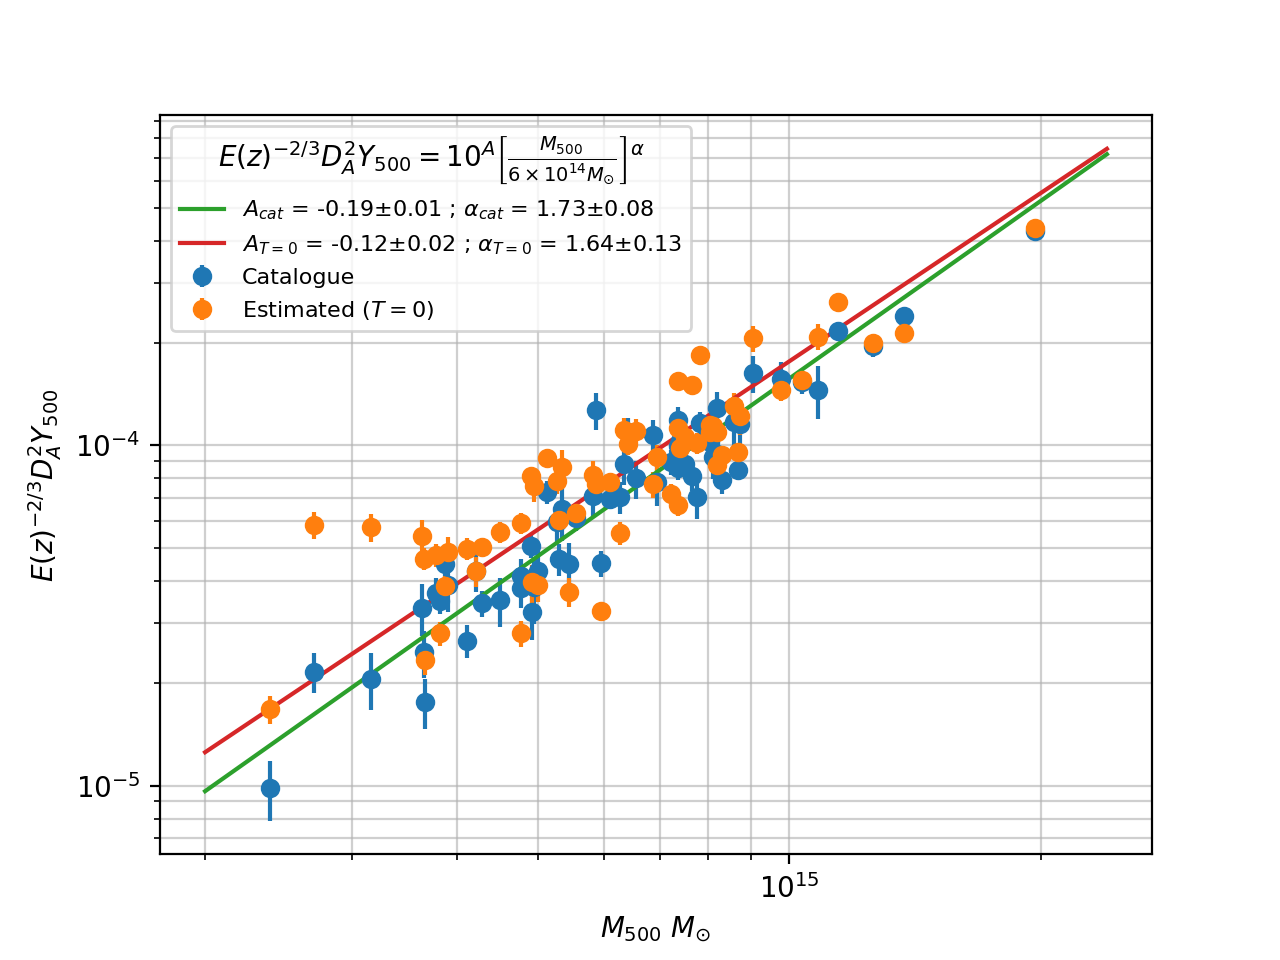

In [19]:
M500=linspace(2,24,1000)
norm=1e-4
figure()
errorbar(xsz_cat["M500"]*1e14,Ezgamma*xsz_cat["YSZ_500"]*norm,yerr=xsz_cat["YSZ_500_err"]*Ezgamma*norm,fmt="o",label="Catalogue")
errorbar(xsz_cat["M500"]*1e14,Ezgamma*bxsz_cat["YSZ_500"]*norm,yerr=bxsz_cat["YSZ_500_err"]*Ezgamma*norm,fmt="o",label="Estimated $(T=0)$")

lbl=r"$A_{cat}$ = " + str(round(bcat[3],2)) + r"$\pm$" + str(round(errbcat[3],2)) 
lbl=lbl + r" ; $\alpha_{cat}$ = " +str(round(acat[3],2))  + r"$\pm$" + str(round(erracat[3],2))
plot(M500*1e14,(10.**bcat[3])*((M500/6.)**acat[3])*norm,label=lbl)

lbl=r"$A_{T=0}$ = " + str(round(bT0[3],2)) + "$\pm$" + str(round(errbT0[3],2)) 
lbl=lbl + r" ; $\alpha_{T=0}$ = " +str(round(aT0[3],2))  + "$\pm$" + str(round(erraT0[3],2))
plot(M500*1e14,(10.**bT0[3])*((M500/6.)**aT0[3])*norm,label=lbl)

ylabel(r"$E(z)^{-2/3} D^2_A Y_{500}$")
xlabel(r"$M_{500}$" + " " + "$M_{\odot}$")
lbl=r"$E(z)^{-2/3} D^2_A Y_{500} = 10^A \left[ \frac{M_{500}}{6 \times 10^{14} M_{\odot}}\right]^\alpha$"
legend(loc=0,title=lbl,fontsize=8)
loglog()
grid(which="both",alpha=0.6)
figname=figpath + "blind_Y500_vs_M500_compare_with_cat.pdf"
savefig(figname,bbox_inches="tight")

<IPython.core.display.Javascript object>


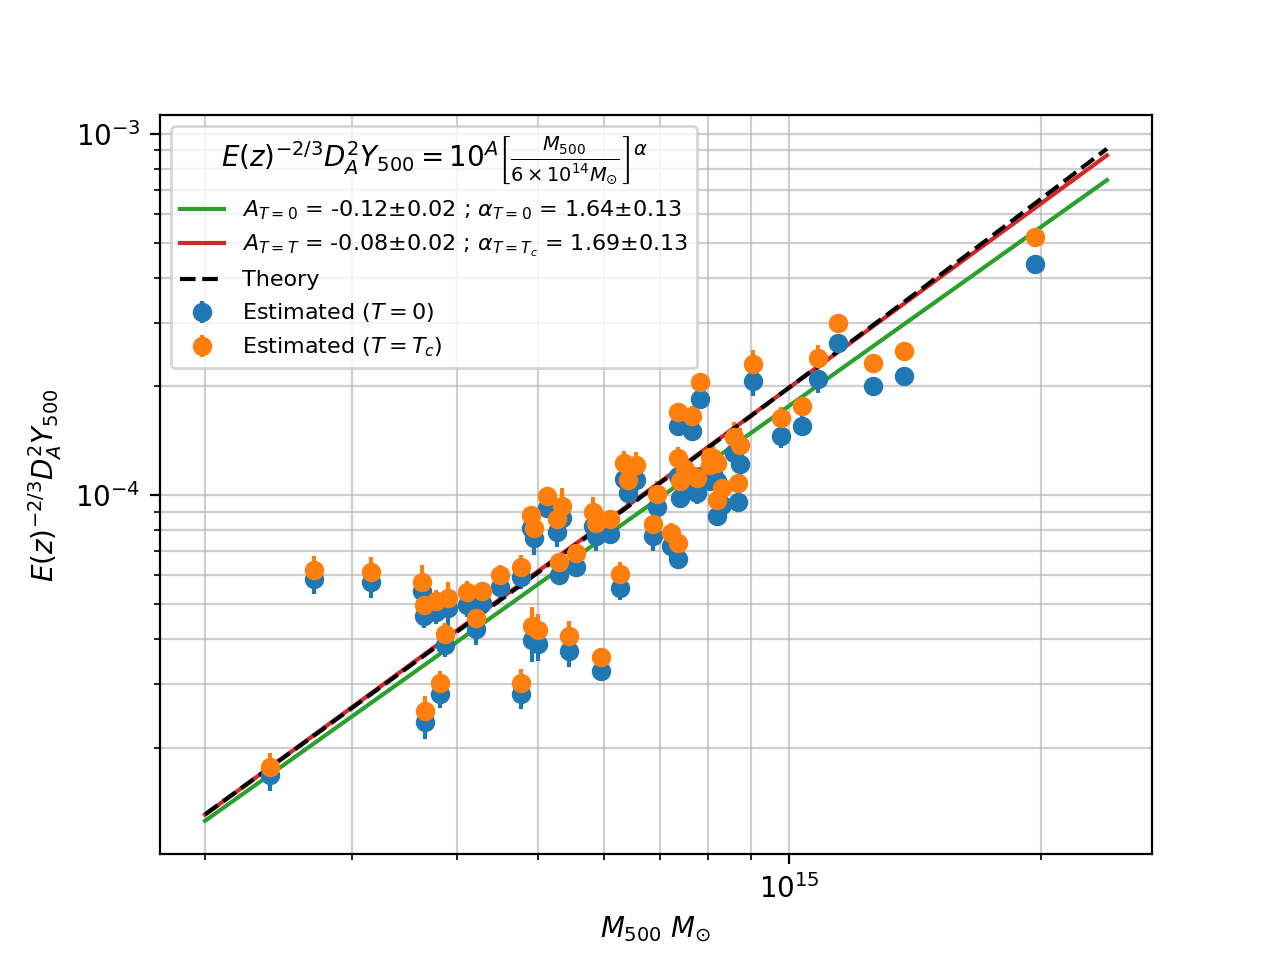

In [20]:
M500=linspace(2,24,1000)
T500=cosmo_fn.convert_M500_T500(M500,0.)
correction=1+0.07*(T500/5.)

norm=1e-4
figure()
errorbar(xsz_cat["M500"]*1e14,Ezgamma*bxsz_cat["YSZ_500"]*norm,yerr=bxsz_cat["YSZ_500_err"]*Ezgamma*norm,fmt="o",label="Estimated $(T=0)$")
errorbar(xsz_cat["M500"]*1e14,Ezgamma*bxsz_cat["YSZ_500_Tc"]*norm,yerr=bxsz_cat["YSZ_500_err_Tc"]*Ezgamma*norm,fmt="o",label="Estimated $(T=T_c)$")

lbl=r"$A_{T=0}$ = " + str(round(bT0[3],2)) + "$\pm$" + str(round(errbT0[3],2)) 
lbl=lbl + r" ; $\alpha_{T=0}$ = " +str(round(aT0[3],2))  + "$\pm$" + str(round(erraT0[3],2))
plot(M500*1e14,(10.**bT0[3])*((M500/6.)**aT0[3])*norm,label=lbl)

lbl=r"$A_{T=T}$ = " + str(round(bTT[3],2)) + r"$\pm$" + str(round(errbTT[3],2)) 
lbl=lbl + r" ; $\alpha_{T=T_c}$ = " +str(round(aTT[3],2))  + r"$\pm$" + str(round(erraTT[3],2))
plot(M500*1e14,(10.**bTT[3])*((M500/6.)**aTT[3])*norm,label=lbl)

plot(M500*1e14,(10.**bT0[3])*((M500/6.)**aT0[3])*norm*correction,"k--",label="Theory")

ylabel(r"$E(z)^{-2/3} D^2_A Y_{500}$")
xlabel(r"$M_{500}$" + " " + "$M_{\odot}$")
lbl=r"$E(z)^{-2/3} D^2_A Y_{500} = 10^A \left[ \frac{M_{500}}{6 \times 10^{14} M_{\odot}}\right]^\alpha$"
legend(loc=0,title=lbl,fontsize=8)
loglog()
grid(which="both",alpha=0.6)
figname=figpath + "blind_Y500_vs_M500_rSZ_correction.pdf"
savefig(figname,bbox_inches="tight")